In [19]:
import pandas as pd


# Specify the file path for the .xlsl file
df = pd.read_excel('/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/Raw_CGM.xlsx', engine='openpyxl')  # 파일 경로 지정


# Display the dataframe
df

,StudyID,Timestamp,Glucose mg/dL,Relative_Day
0,1,2022-10-06 01:34:00,78,1
1,1,2022-10-06 01:49:00,76,1
2,1,2022-10-06 02:04:00,78,1
3,1,2022-10-06 02:19:00,75,1
4,1,2022-10-06 02:34:00,75,1
...,...,...,...,...
71712,89,2023-05-09 19:08:00,114,14
71713,89,2023-05-09 19:23:00,136,14
71714,89,2023-05-09 19:38:00,142,14
71715,89,2023-05-09 19:53:00,137,14


# Add Look back mean&SD (3,5,7)

In [20]:
import pandas as pd


# Convert Timestamp to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Define the rolling window sizes
window_sizes = [3, 5, 7]

# Initialize new columns with NaN
for window in window_sizes:
    df[f"Glucose_Mean_{window}d"] = None
    df[f"Glucose_SD_{window}d"] = None
    df[f"Threshold_{window}d"] = None

# Process each StudyID separately
for study_id in df["StudyID"].unique():
    study_df = df[df["StudyID"] == study_id].copy()

    for window in window_sizes:
        # Iterate over unique Relative_Day values starting from the valid range
        for day in study_df["Relative_Day"].unique():
            if day < (window + 1):  # Ensure calculations only happen from the correct start day
                continue
            
            # Select data within the rolling window range based on Relative_Day
            window_days = study_df[(study_df["Relative_Day"] >= day - (window - 1)) & 
                                   (study_df["Relative_Day"] <= day)]
            
            # Compute mean and standard deviation if enough data points are available
            if len(window_days) >= window:
                mean_val = window_days["Glucose mg/dL"].mean()
                std_val = window_days["Glucose mg/dL"].std()
                threshold_val = mean_val + 1.5 * std_val

                # Assign calculated values to the corresponding rows in the main dataframe
                df.loc[(df["StudyID"] == study_id) & (df["Relative_Day"] == day), f"Glucose_Mean_{window}d"] = mean_val
                df.loc[(df["StudyID"] == study_id) & (df["Relative_Day"] == day), f"Glucose_SD_{window}d"] = std_val
                df.loc[(df["StudyID"] == study_id) & (df["Relative_Day"] == day), f"Threshold_{window}d"] = threshold_val

# Ensure that values are only calculated starting from the correct Relative_Day
for window in window_sizes:
    df.loc[df["Relative_Day"] < (window + 1), [f"Glucose_Mean_{window}d", f"Glucose_SD_{window}d", f"Threshold_{window}d"]] = None


df


,StudyID,Timestamp,Glucose mg/dL,Relative_Day,Glucose_Mean_3d,Glucose_SD_3d,Threshold_3d,Glucose_Mean_5d,Glucose_SD_5d,Threshold_5d,Glucose_Mean_7d,Glucose_SD_7d,Threshold_7d
0,1,2022-10-06 01:34:00,78,1,None,None,None,None,None,None,None,None,None
1,1,2022-10-06 01:49:00,76,1,None,None,None,None,None,None,None,None,None
2,1,2022-10-06 02:04:00,78,1,None,None,None,None,None,None,None,None,None
3,1,2022-10-06 02:19:00,75,1,None,None,None,None,None,None,None,None,None
4,1,2022-10-06 02:34:00,75,1,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71712,89,2023-05-09 19:08:00,114,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099
71713,89,2023-05-09 19:23:00,136,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099
71714,89,2023-05-09 19:38:00,142,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099
71715,89,2023-05-09 19:53:00,137,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099


In [21]:
# Save the updated dataset (optional)
df.to_excel("3_5_7_Threshold.xlsx", index=False)


# ADD GE count

In [25]:
import pandas as pd
import numpy as np



# Define the rolling window sizes
window_sizes = [3, 5, 7]

# Function to calculate GE and total GE count
def calculate_ge_metrics(df, window):
    # Replace NaN values in threshold column to prevent comparison errors
    df[f"Threshold_{window}d"] = pd.to_numeric(df[f"Threshold_{window}d"], errors="coerce")

    # Create a new column to indicate if Glucose mg/dL exceeds the threshold
    df[f"GE_{window}d"] = np.where(
        (df["Glucose mg/dL"].notna()) & (df[f"Threshold_{window}d"].notna()) & 
        (df["Glucose mg/dL"] > df[f"Threshold_{window}d"]),
        1, 0
    )

    # Initialize Total GE column
    df[f"Total_GE_{window}d"] = 0

    for study_id in df["StudyID"].unique():
        study_df = df[df["StudyID"] == study_id].copy()
        
        for day in study_df["Relative_Day"].unique():
            day_df = study_df[study_df["Relative_Day"] == day]

            # Identify GE sequences
            ge_values = day_df[f"GE_{window}d"].values
            total_ge_count = 0
            in_ge_sequence = False

            for ge in ge_values:
                if ge == 1 and not in_ge_sequence:
                    total_ge_count += 1
                    in_ge_sequence = True
                elif ge == 0:
                    in_ge_sequence = False

            # Assign the total GE count for the day
            df.loc[(df["StudyID"] == study_id) & (df["Relative_Day"] == day), f"Total_GE_{window}d"] = total_ge_count

# Apply GE calculation for each window size (3, 5, 7 days)
for window in window_sizes:
    calculate_ge_metrics(df, window)

df


,StudyID,Timestamp,Glucose mg/dL,Relative_Day,Glucose_Mean_3d,Glucose_SD_3d,Threshold_3d,Glucose_Mean_5d,Glucose_SD_5d,Threshold_5d,Glucose_Mean_7d,Glucose_SD_7d,Threshold_7d,GE_3d,Total_GE_3d,GE_5d,Total_GE_5d,GE_7d,Total_GE_7d
0,1,2022-10-06 01:34:00,78,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
1,1,2022-10-06 01:49:00,76,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
2,1,2022-10-06 02:04:00,78,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
3,1,2022-10-06 02:19:00,75,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
4,1,2022-10-06 02:34:00,75,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71712,89,2023-05-09 19:08:00,114,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099,0,4,0,3,0,4
71713,89,2023-05-09 19:23:00,136,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099,1,4,1,3,1,4
71714,89,2023-05-09 19:38:00,142,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099,1,4,1,3,1,4
71715,89,2023-05-09 19:53:00,137,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099,1,4,1,3,1,4


In [26]:
# Save the updated dataset (optional)
df.to_excel("3_5_7_GE_count.xlsx", index=False)


In [27]:
import pandas as pd
import numpy as np



# Summarize total unique GE count for each StudyID across different lookback windows
# Instead of summing all values, count unique non-zero occurrences per day per participant
summary_df_corrected = df.groupby(["StudyID", "Relative_Day"])[["Total_GE_3d", "Total_GE_5d", "Total_GE_7d"]].max().reset_index()
final_summary = summary_df_corrected.groupby("StudyID")[["Total_GE_3d", "Total_GE_5d", "Total_GE_7d"]].sum().reset_index()

df

,StudyID,Timestamp,Glucose mg/dL,Relative_Day,Glucose_Mean_3d,Glucose_SD_3d,Threshold_3d,Glucose_Mean_5d,Glucose_SD_5d,Threshold_5d,Glucose_Mean_7d,Glucose_SD_7d,Threshold_7d,GE_3d,Total_GE_3d,GE_5d,Total_GE_5d,GE_7d,Total_GE_7d
0,1,2022-10-06 01:34:00,78,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
1,1,2022-10-06 01:49:00,76,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
2,1,2022-10-06 02:04:00,78,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
3,1,2022-10-06 02:19:00,75,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
4,1,2022-10-06 02:34:00,75,1,None,None,NaN,None,None,NaN,None,None,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71712,89,2023-05-09 19:08:00,114,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099,0,4,0,3,0,4
71713,89,2023-05-09 19:23:00,136,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099,1,4,1,3,1,4
71714,89,2023-05-09 19:38:00,142,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099,1,4,1,3,1,4
71715,89,2023-05-09 19:53:00,137,14,98.930403,15.77154,122.587712,99.012903,18.004185,126.019181,98.252664,16.875624,123.566099,1,4,1,3,1,4


In [28]:
# Save the updated dataset (optional)
df.to_excel("3_5_7_GE_total.xlsx", index=False)

# Total GE counts 3,5,7 in total days

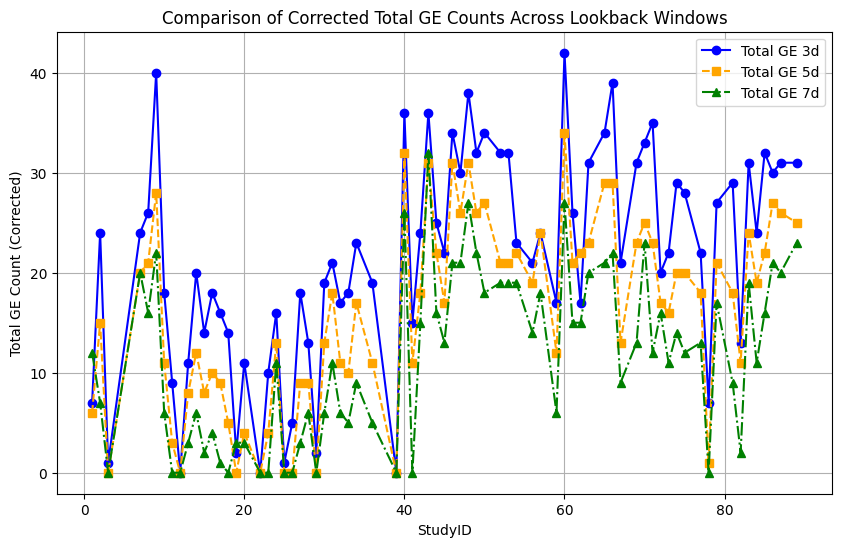

In [29]:
import matplotlib.pyplot as plt

# Define colors and line styles for better differentiation
colors = {3: 'blue', 5: 'orange', 7: 'green'}
markers = {3: 'o', 5: 's', 7: '^'}
linestyles = {3: '-', 5: '--', 7: '-.'}

# Plot corrected comparison of Total GE counts for different lookback windows
plt.figure(figsize=(10, 6))

for window in [3, 5, 7]:
    plt.plot(
        final_summary["StudyID"], final_summary[f"Total_GE_{window}d"],
        marker=markers[window], linestyle=linestyles[window],
        color=colors[window], label=f"Total GE {window}d"
    )

plt.xlabel("StudyID")
plt.ylabel("Total GE Count (Corrected)")
plt.title("Comparison of Corrected Total GE Counts Across Lookback Windows")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Total GE counts 3,5,7 on day 8


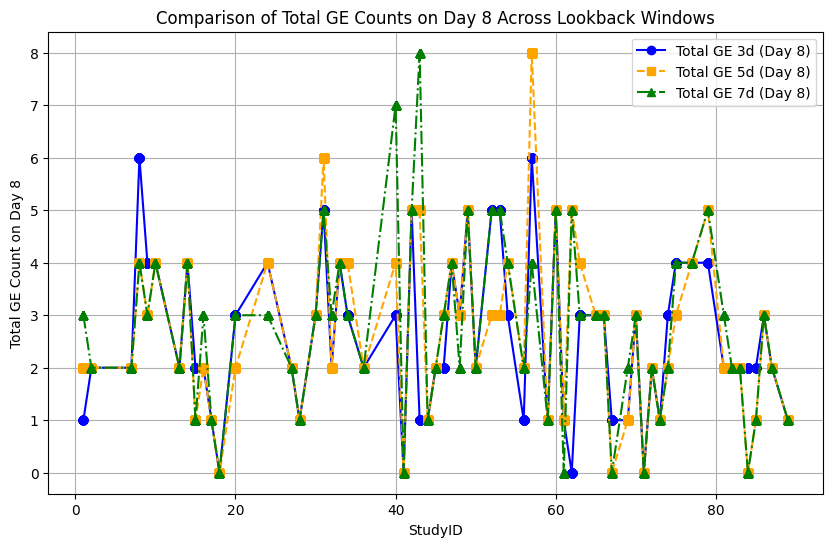

       StudyID  Total_GE_3d  Total_GE_5d  Total_GE_7d
490          1            1            2            3
491          1            1            2            3
492          1            1            2            3
493          1            1            2            3
494          1            1            2            3
...        ...          ...          ...          ...
71151       89            1            1            1
71152       89            1            1            1
71153       89            1            1            1
71154       89            1            1            1
71155       89            1            1            1

[5878 rows x 4 columns]


In [31]:
import pandas as pd
import matplotlib.pyplot as plt



# Filter the dataset for only Relative_Day == 8
day_8_ge_counts = df[df["Relative_Day"] == 8][["StudyID", "Total_GE_3d", "Total_GE_5d", "Total_GE_7d"]]

# Define colors and line styles for better differentiation
colors = {3: 'blue', 5: 'orange', 7: 'green'}
markers = {3: 'o', 5: 's', 7: '^'}
linestyles = {3: '-', 5: '--', 7: '-.'}

# Plot comparison of Total GE counts for different lookback windows on day 8
plt.figure(figsize=(10, 6))

for window in [3, 5, 7]:
    plt.plot(
        day_8_ge_counts["StudyID"], day_8_ge_counts[f"Total_GE_{window}d"],
        marker=markers[window], linestyle=linestyles[window],
        color=colors[window], label=f"Total GE {window}d (Day 8)"
    )

plt.xlabel("StudyID")
plt.ylabel("Total GE Count on Day 8")
plt.title("Comparison of Total GE Counts on Day 8 Across Lookback Windows")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display the Total GE counts for Day 8
print(day_8_ge_counts)


# Total GE counts 3,5,7 on day 9


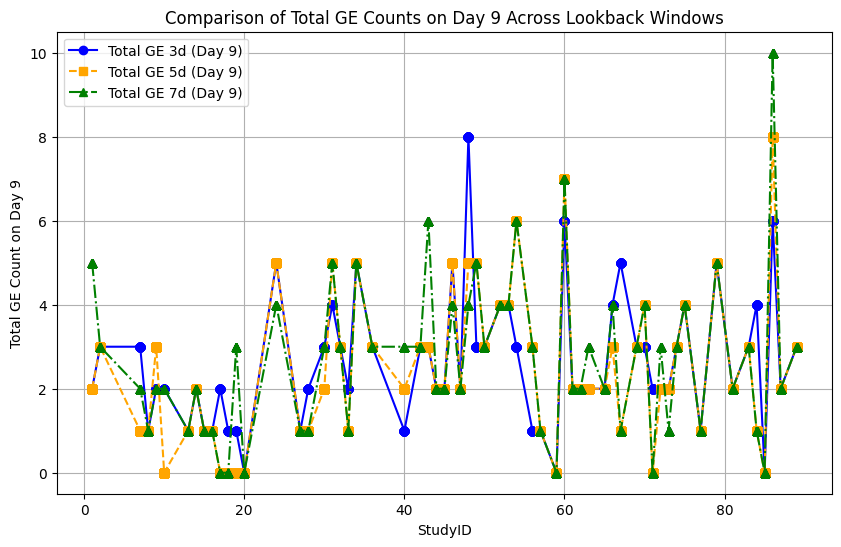

       StudyID  Total_GE_3d  Total_GE_5d  Total_GE_7d
536          1            2            2            5
537          1            2            2            5
538          1            2            2            5
539          1            2            2            5
540          1            2            2            5
...        ...          ...          ...          ...
71247       89            3            3            3
71248       89            3            3            3
71249       89            3            3            3
71250       89            3            3            3
71251       89            3            3            3

[5498 rows x 4 columns]


In [35]:
# Filter the dataset for only Relative_Day == 9
day_9_ge_counts = df[df["Relative_Day"] == 9][["StudyID", "Total_GE_3d", "Total_GE_5d", "Total_GE_7d"]]

# Define colors and line styles for better differentiation
colors = {3: 'blue', 5: 'orange', 7: 'green'}
markers = {3: 'o', 5: 's', 7: '^'}
linestyles = {3: '-', 5: '--', 7: '-.'}

# Plot comparison of Total GE counts for different lookback windows on day 9
plt.figure(figsize=(10, 6))

for window in [3, 5, 7]:
    plt.plot(
        day_9_ge_counts["StudyID"], day_9_ge_counts[f"Total_GE_{window}d"],
        marker=markers[window], linestyle=linestyles[window],
        color=colors[window], label=f"Total GE {window}d (Day 9)"
    )

plt.xlabel("StudyID")
plt.ylabel("Total GE Count on Day 9")
plt.title("Comparison of Total GE Counts on Day 9 Across Lookback Windows")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display the Total GE counts for Day 9
print(day_9_ge_counts)

# Total GE counts 3,5,7 on day 10


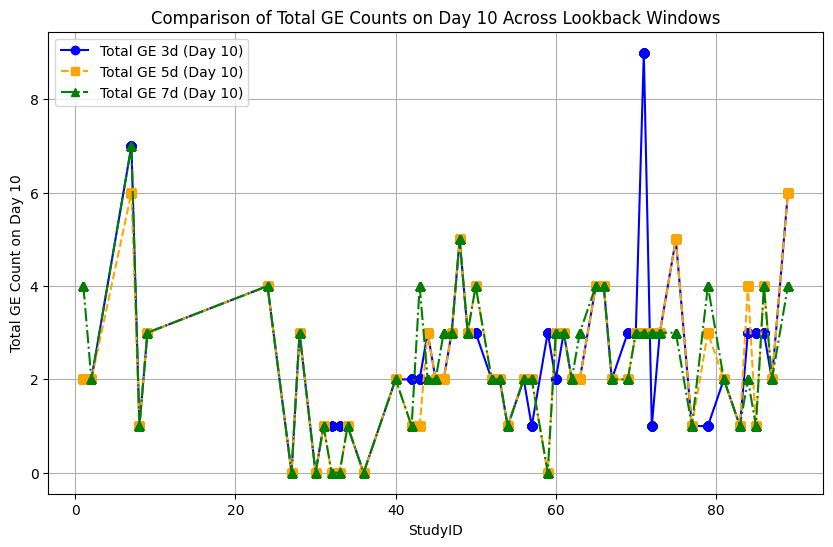

       StudyID  Total_GE_3d  Total_GE_5d  Total_GE_7d
632          1            2            2            4
633          1            2            2            4
634          1            2            2            4
635          1            2            2            4
636          1            2            2            4
...        ...          ...          ...          ...
71343       89            6            6            4
71344       89            6            6            4
71345       89            6            6            4
71346       89            6            6            4
71347       89            6            6            4

[4480 rows x 4 columns]


In [37]:
# Filter the dataset for only Relative_Day == 10
day_10_ge_counts = df[df["Relative_Day"] == 10][["StudyID", "Total_GE_3d", "Total_GE_5d", "Total_GE_7d"]]

# Define colors and line styles for better differentiation
colors = {3: 'blue', 5: 'orange', 7: 'green'}
markers = {3: 'o', 5: 's', 7: '^'}
linestyles = {3: '-', 5: '--', 7: '-.'}

# Plot comparison of Total GE counts for different lookback windows on day 10
plt.figure(figsize=(10, 6))

for window in [3, 5, 7]:
    plt.plot(
        day_10_ge_counts["StudyID"], day_10_ge_counts[f"Total_GE_{window}d"],
        marker=markers[window], linestyle=linestyles[window],
        color=colors[window], label=f"Total GE {window}d (Day 10)"
    )

plt.xlabel("StudyID")
plt.ylabel("Total GE Count on Day 10")
plt.title("Comparison of Total GE Counts on Day 10 Across Lookback Windows")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display the Total GE counts for Day 10
print(day_10_ge_counts)

# Total GE counts 3,5,7 on day 13


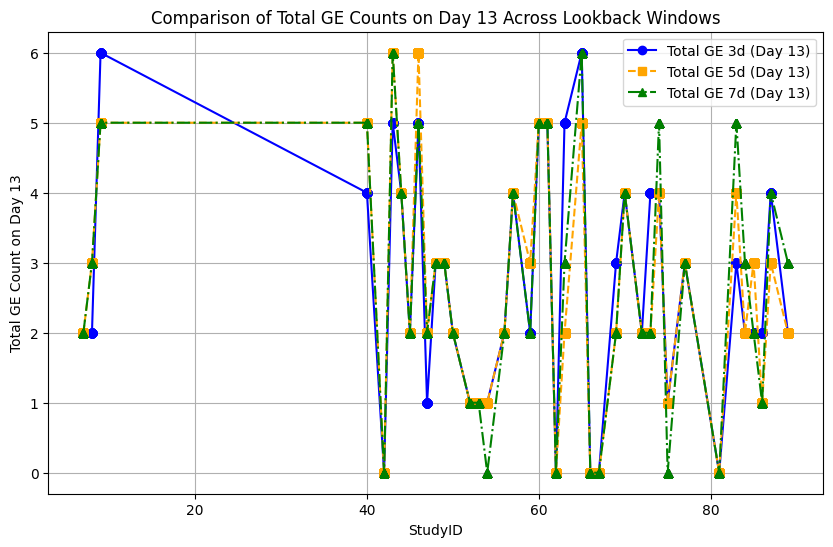

       StudyID  Total_GE_3d  Total_GE_5d  Total_GE_7d
3069         7            2            2            2
3070         7            2            2            2
3071         7            2            2            2
3072         7            2            2            2
3073         7            2            2            2
...        ...          ...          ...          ...
71631       89            2            2            3
71632       89            2            2            3
71633       89            2            2            3
71634       89            2            2            3
71635       89            2            2            3

[3682 rows x 4 columns]


In [41]:
# Filter the dataset for only Relative_Day == 13
day_13_ge_counts = df[df["Relative_Day"] == 13][["StudyID", "Total_GE_3d", "Total_GE_5d", "Total_GE_7d"]]

# Define colors and line styles for better differentiation
colors = {3: 'blue', 5: 'orange', 7: 'green'}
markers = {3: 'o', 5: 's', 7: '^'}
linestyles = {3: '-', 5: '--', 7: '-.'}

# Plot comparison of Total GE counts for different lookback windows on day 13
plt.figure(figsize=(10, 6))

for window in [3, 5, 7]:
    plt.plot(
        day_13_ge_counts["StudyID"], day_13_ge_counts[f"Total_GE_{window}d"],
        marker=markers[window], linestyle=linestyles[window],
        color=colors[window], label=f"Total GE {window}d (Day 13)"
    )

plt.xlabel("StudyID")
plt.ylabel("Total GE Count on Day 13")
plt.title("Comparison of Total GE Counts on Day 13 Across Lookback Windows")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display the Total GE counts for Day 13
print(day_13_ge_counts)

# Total GE counts 3,5,7 on day 14


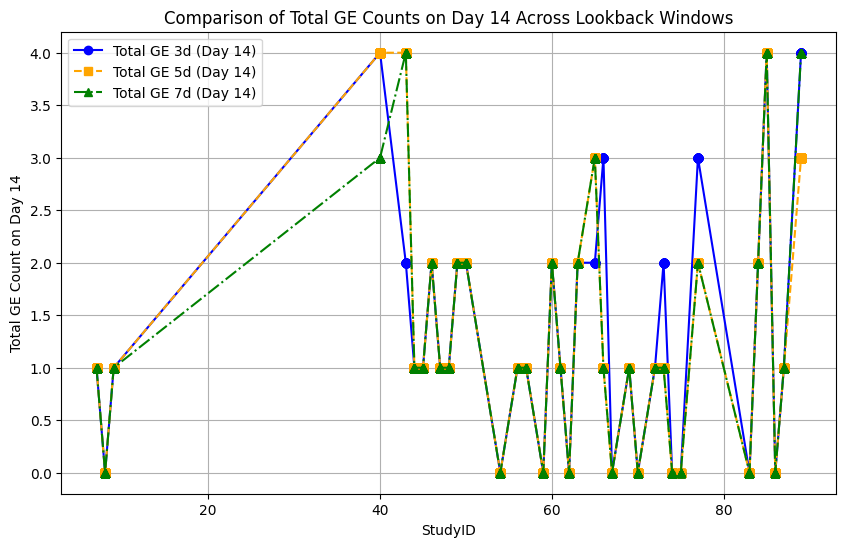

       StudyID  Total_GE_3d  Total_GE_5d  Total_GE_7d
3165         7            1            1            1
3166         7            1            1            1
3167         7            1            1            1
3168         7            1            1            1
3169         7            1            1            1
...        ...          ...          ...          ...
71712       89            4            3            4
71713       89            4            3            4
71714       89            4            3            4
71715       89            4            3            4
71716       89            4            3            4

[2243 rows x 4 columns]


In [40]:
# Filter the dataset for only Relative_Day == 14
day_14_ge_counts = df[df["Relative_Day"] == 14][["StudyID", "Total_GE_3d", "Total_GE_5d", "Total_GE_7d"]]

# Define colors and line styles for better differentiation
colors = {3: 'blue', 5: 'orange', 7: 'green'}
markers = {3: 'o', 5: 's', 7: '^'}
linestyles = {3: '-', 5: '--', 7: '-.'}

# Plot comparison of Total GE counts for different lookback windows on day 14
plt.figure(figsize=(10, 6))

for window in [3, 5, 7]:
    plt.plot(
        day_14_ge_counts["StudyID"], day_14_ge_counts[f"Total_GE_{window}d"],
        marker=markers[window], linestyle=linestyles[window],
        color=colors[window], label=f"Total GE {window}d (Day 14)"
    )

plt.xlabel("StudyID")
plt.ylabel("Total GE Count on Day 14")
plt.title("Comparison of Total GE Counts on Day 14 Across Lookback Windows")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Display the Total GE counts for Day 14
print(day_14_ge_counts)

# Random 3 participants with 3,5,7 threshold and GE on day 8

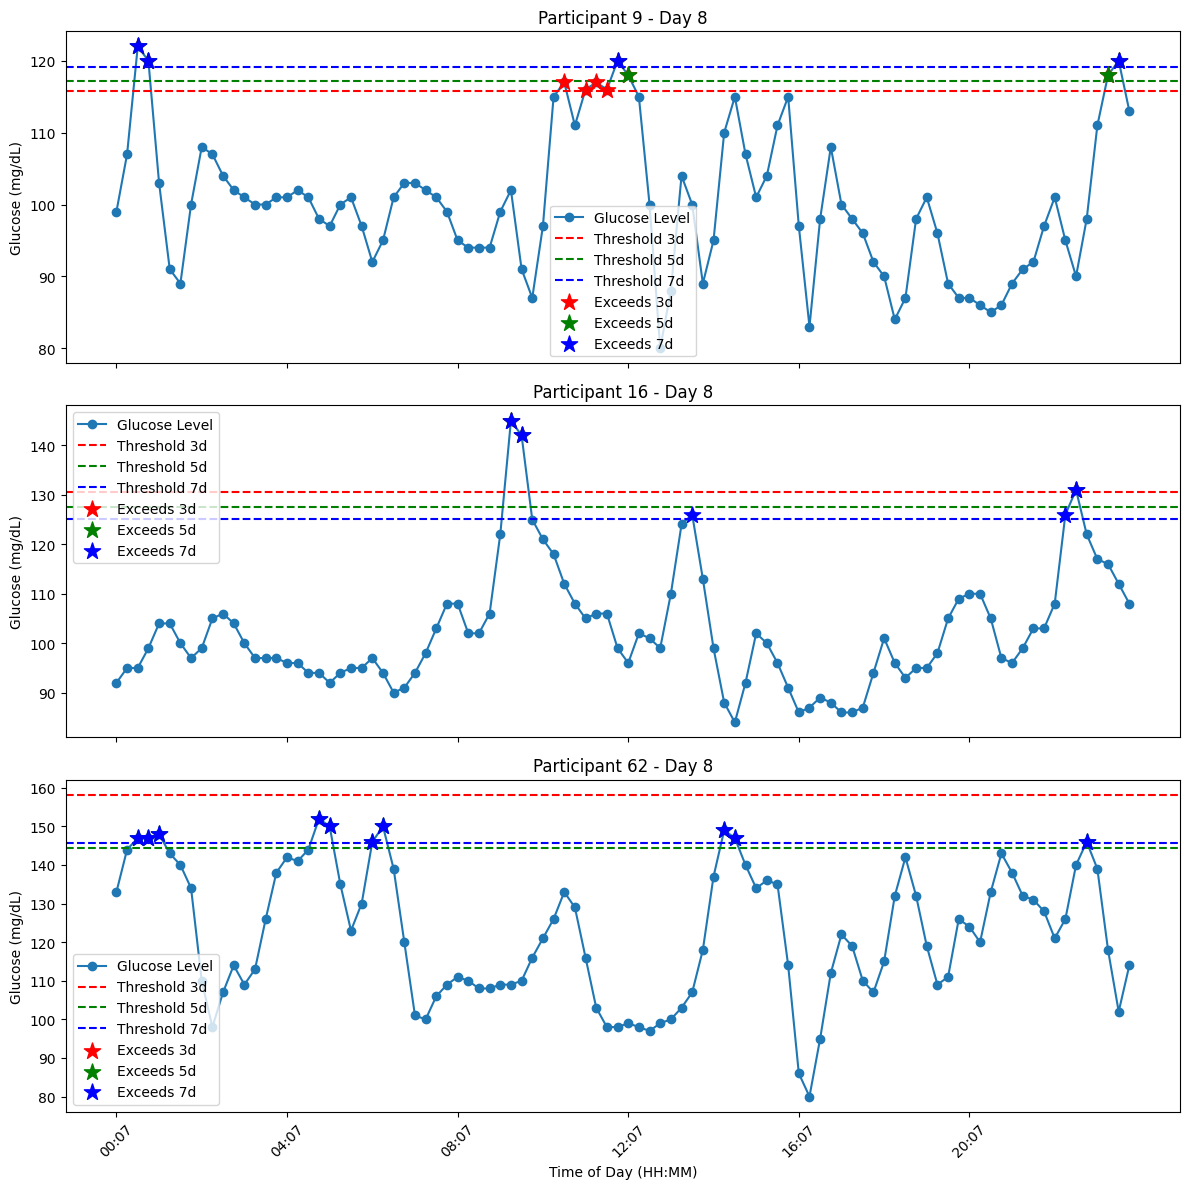

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Filter data for day8
day8_df = df[df["Relative_Day"] == 8]

# Randomly select 3 participants
random_ids = np.random.choice(day8_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day8_df[day8_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 8")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()


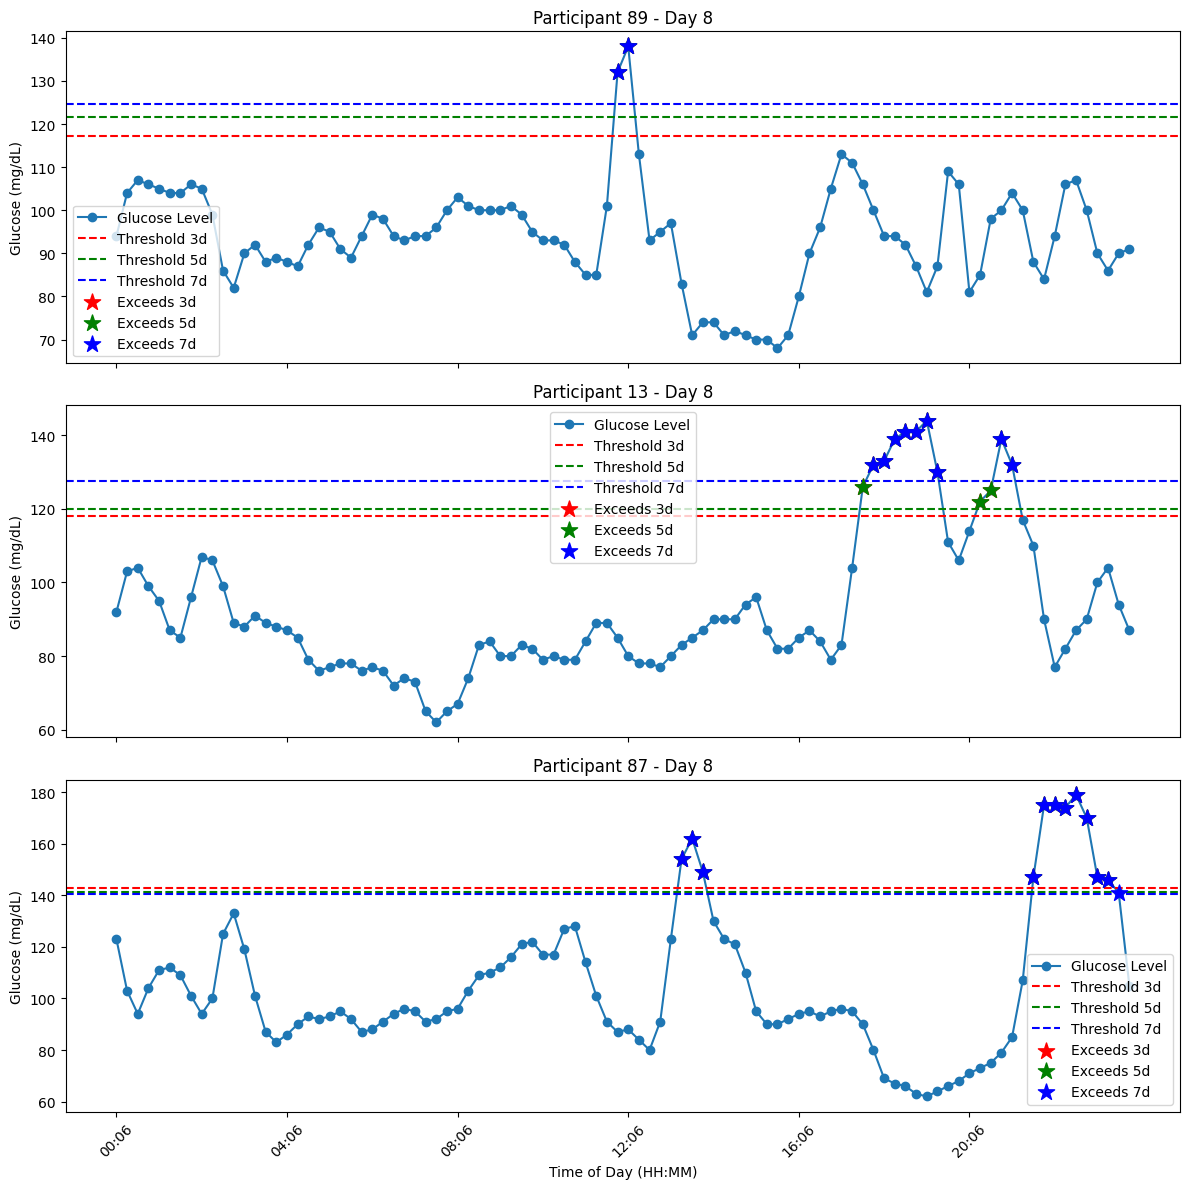

In [44]:

# Filter data for day8
day8_df = df[df["Relative_Day"] == 8]

# Randomly select 3 participants
random_ids = np.random.choice(day8_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day8_df[day8_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 8")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()


# Random 3 participants with threshold and GE on day 9

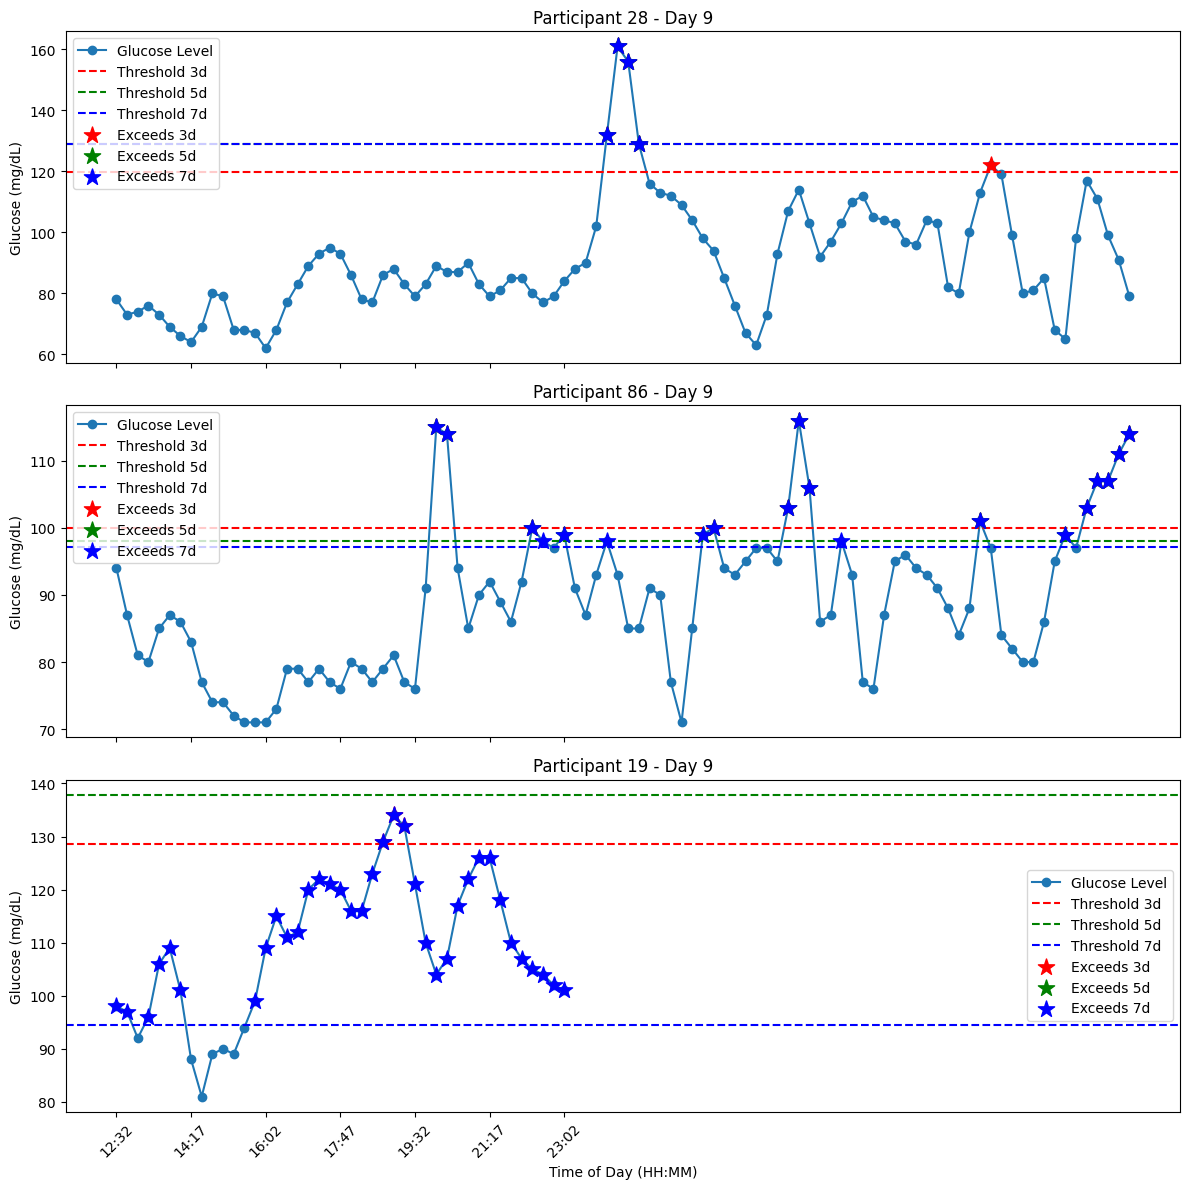

In [48]:

# Filter data for day9
day9_df = df[df["Relative_Day"] == 9]

# Randomly select 3 participants
random_ids = np.random.choice(day9_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day9_df[day9_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 9")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()


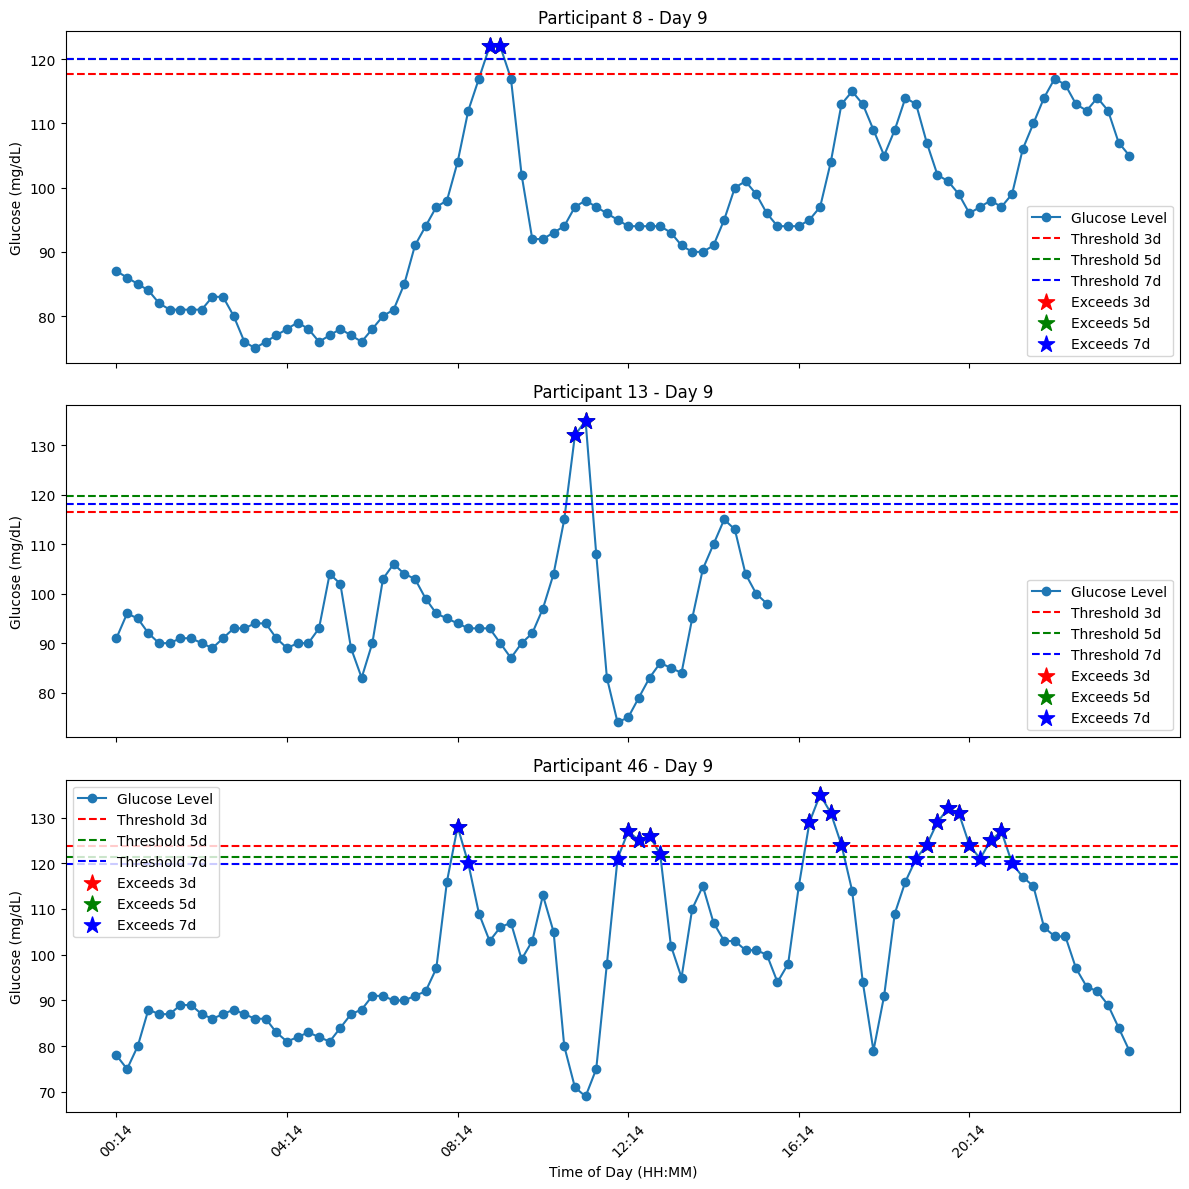

In [49]:
# Filter data for day9
day9_df = df[df["Relative_Day"] == 9]

# Randomly select 3 participants
random_ids = np.random.choice(day9_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day9_df[day9_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 9")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()


# Random 3 participants with threshold and GE on day 10

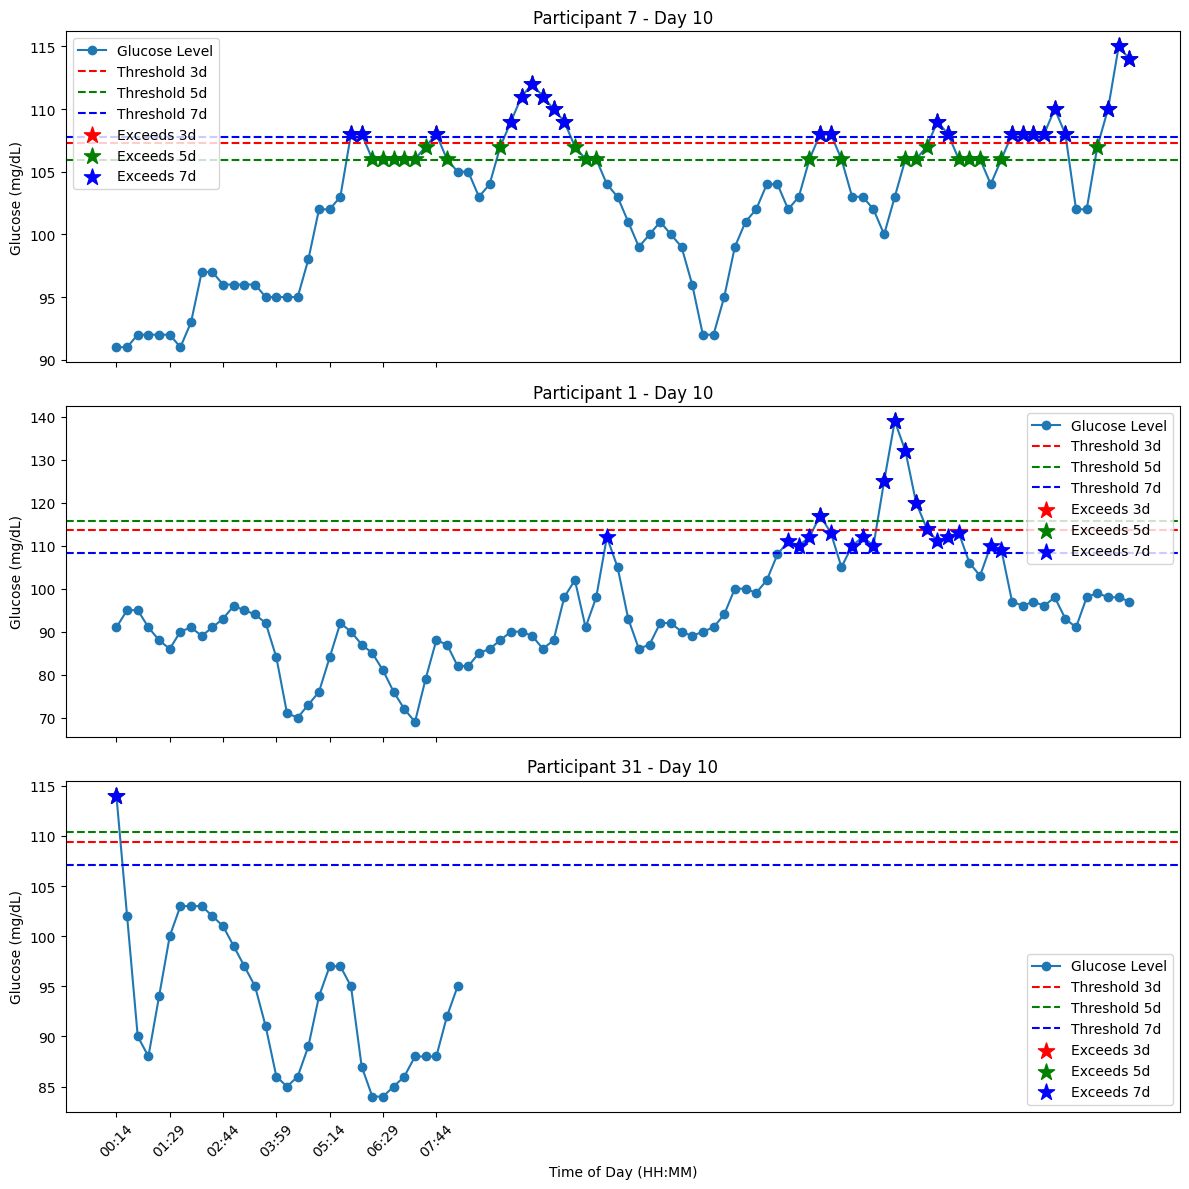

In [50]:
# Filter data for day 10
day10_df = df[df["Relative_Day"] == 10]

# Randomly select 3 participants
random_ids = np.random.choice(day10_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day10_df[day10_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 10")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()


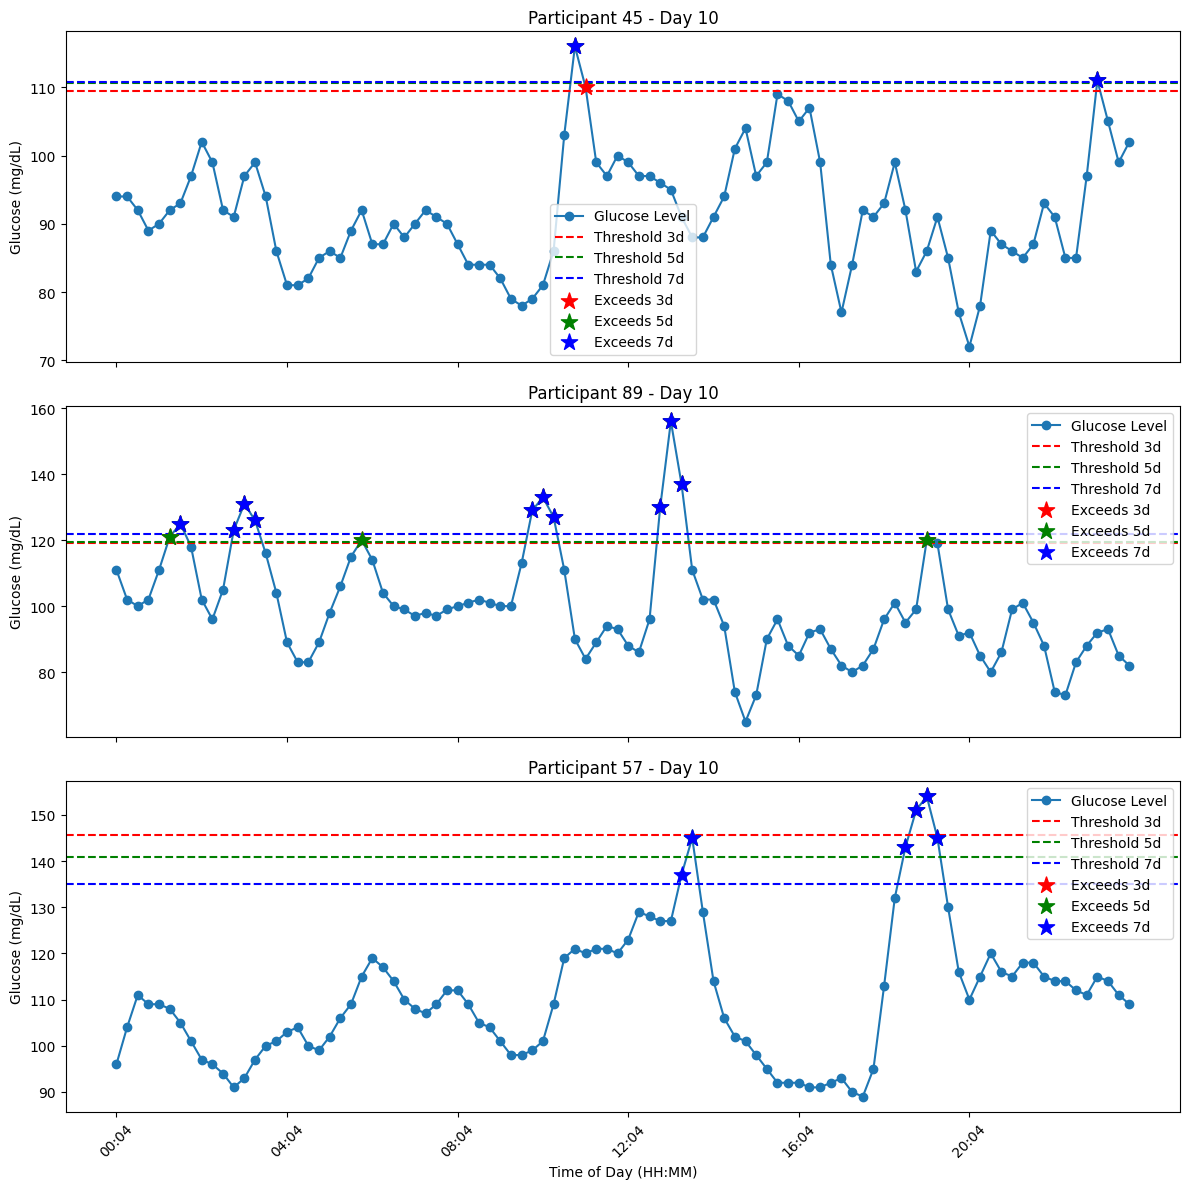

In [51]:
# Filter data for day 10
day10_df = df[df["Relative_Day"] == 10]

# Randomly select 3 participants
random_ids = np.random.choice(day10_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day10_df[day10_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 10")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()


# Random 3 participants with threshold and GE on day 13


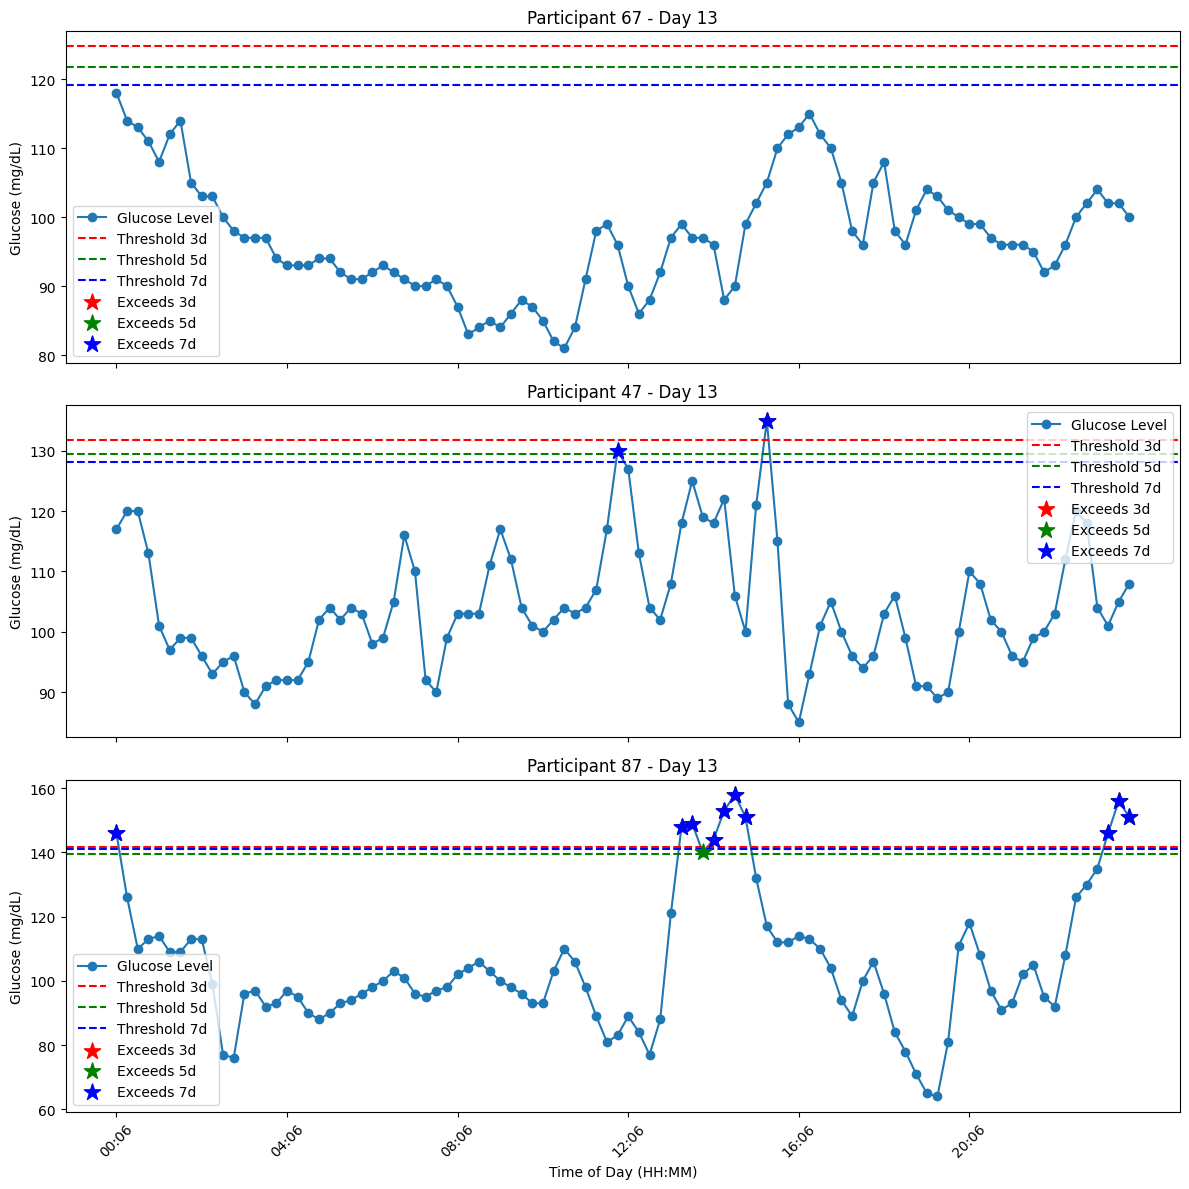

In [52]:
# Filter data for day 13
day13_df = df[df["Relative_Day"] == 13]

# Randomly select 3 participants
random_ids = np.random.choice(day13_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day13_df[day13_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 13")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()

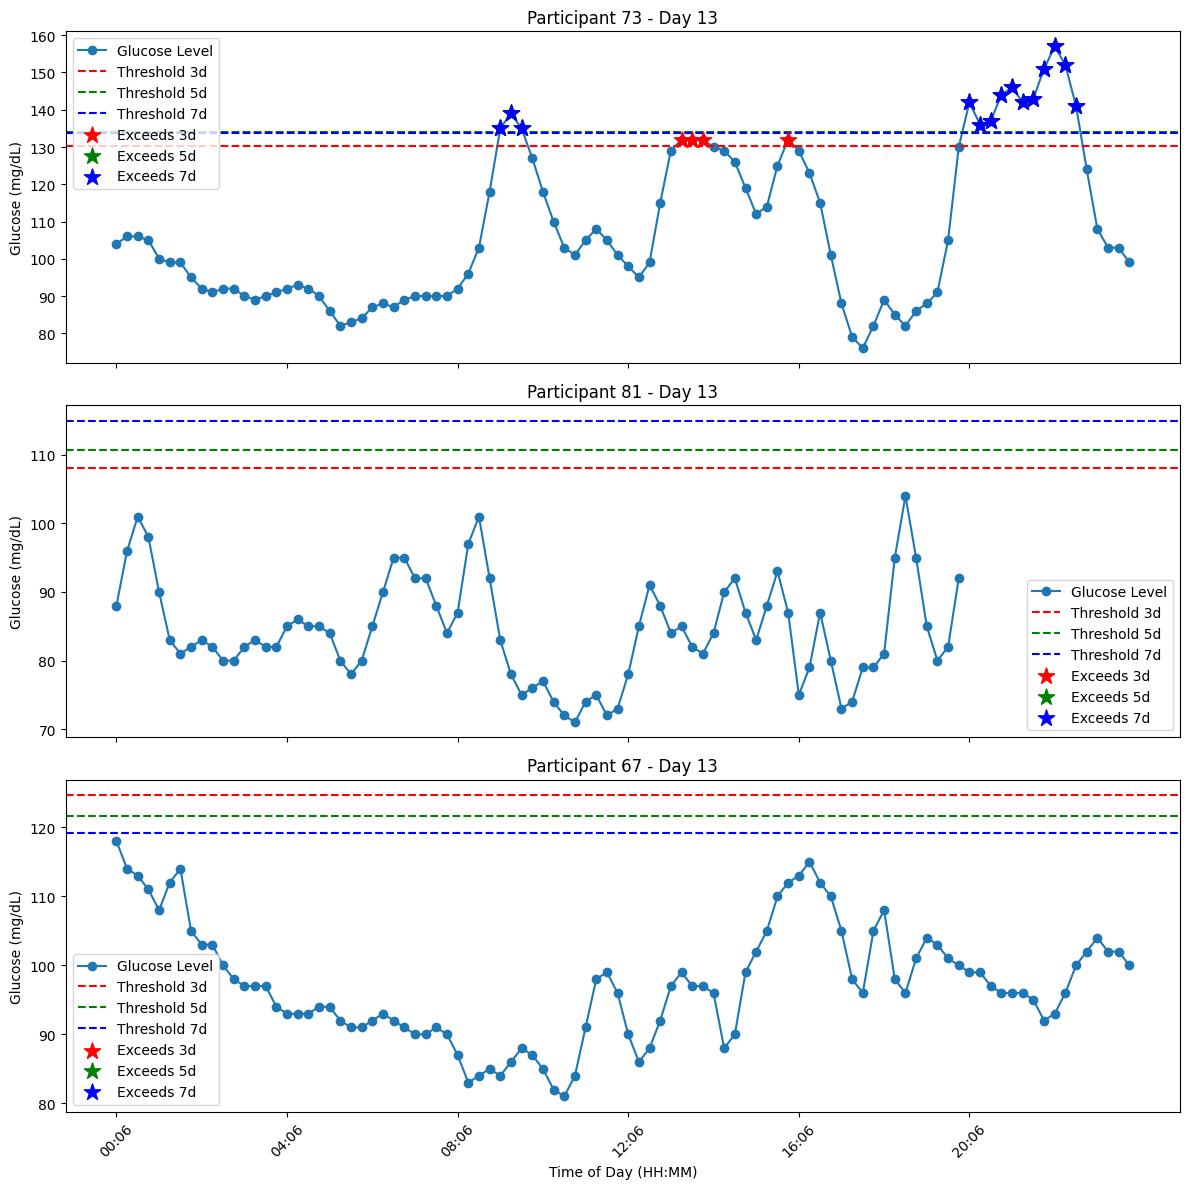

In [53]:
# Filter data for day 13
day13_df = df[df["Relative_Day"] == 13]

# Randomly select 3 participants
random_ids = np.random.choice(day13_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day13_df[day13_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 13")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()

# Day 14


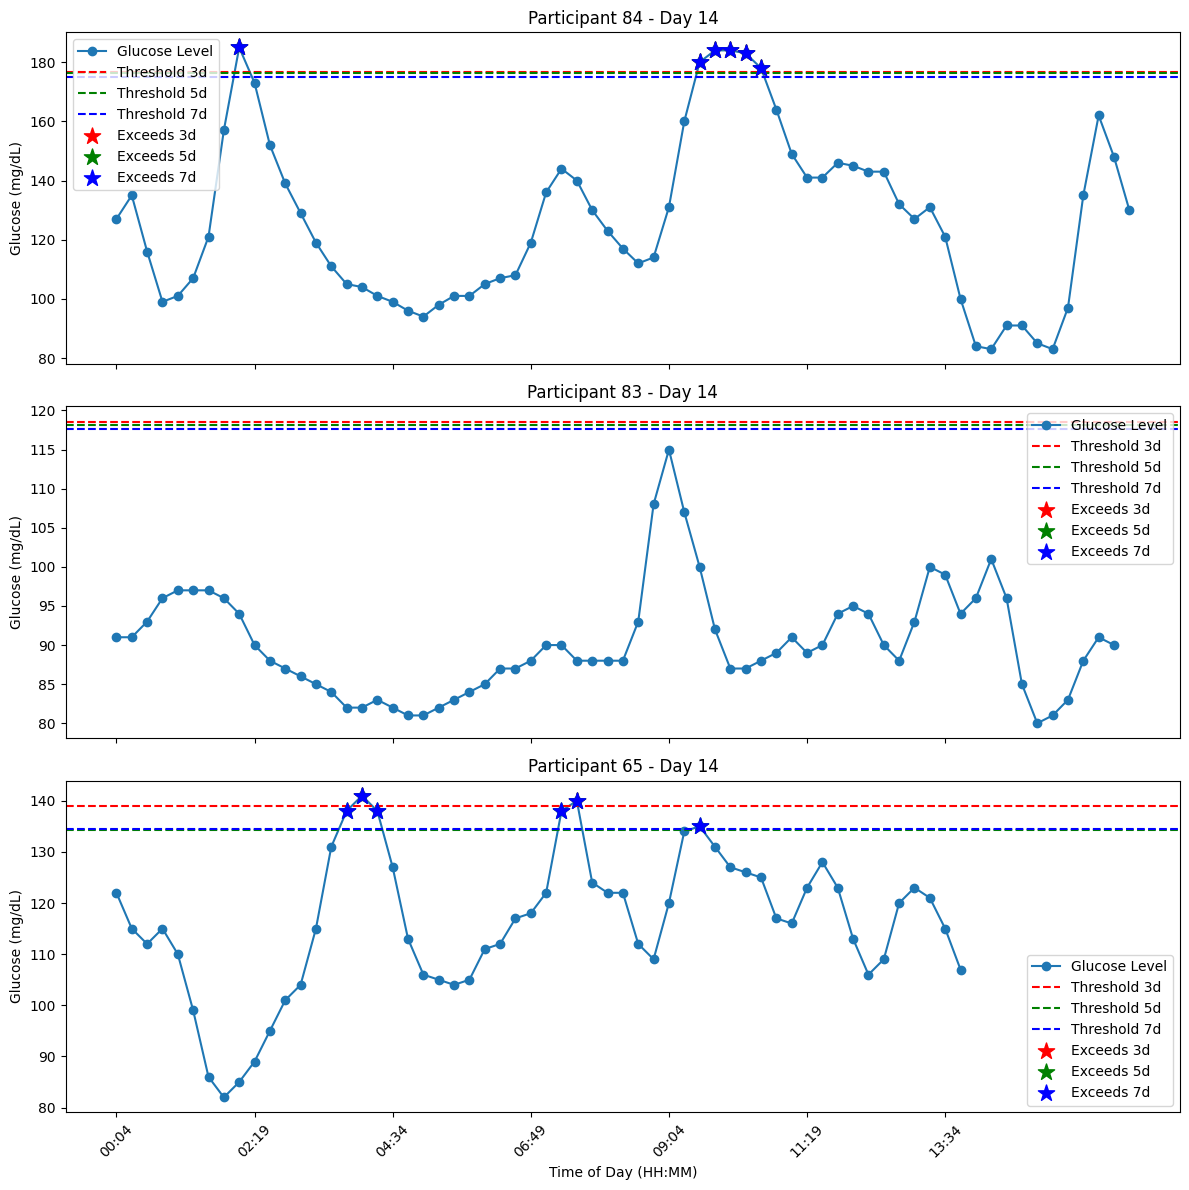

In [55]:
# Filter data for day 14
day14_df = df[df["Relative_Day"] == 14]

# Randomly select 3 participants
random_ids = np.random.choice(day14_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day14_df[day14_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 14")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()

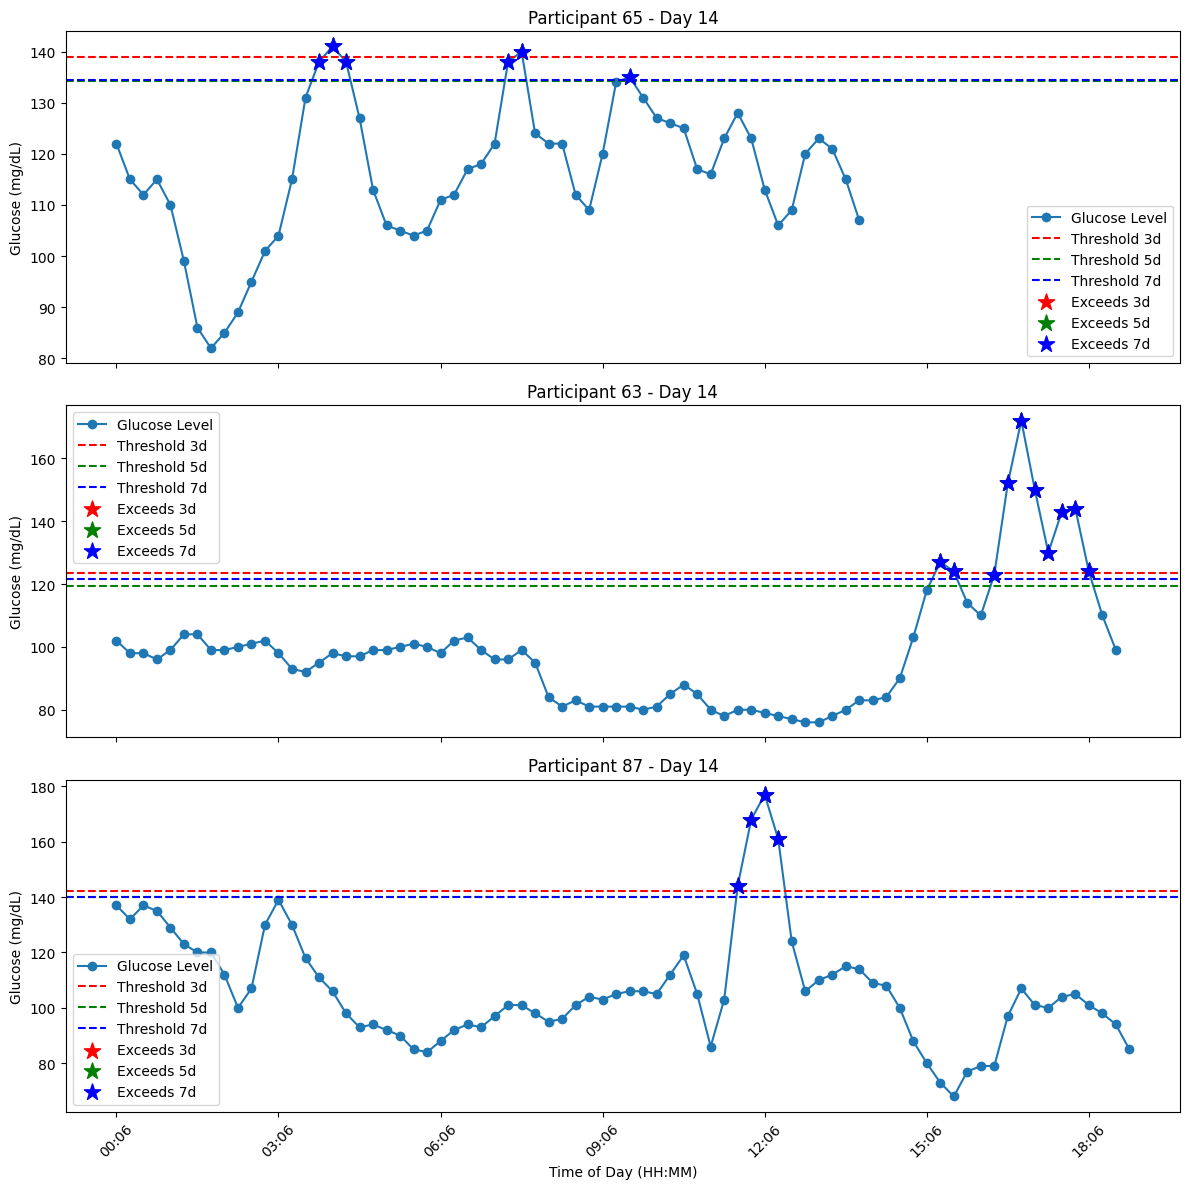

In [56]:
# Filter data for day 14
day14_df = df[df["Relative_Day"] == 14]

# Randomly select 3 participants
random_ids = np.random.choice(day14_df["StudyID"].unique(), 3, replace=False)

# Filter data for selected participants
selected_data = day14_df[day14_df["StudyID"].isin(random_ids)]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, study_id in enumerate(random_ids):
    participant_data = selected_data[selected_data["StudyID"] == study_id]
    
    # Convert timestamps to relative time (HH:MM format)
    relative_times = pd.to_datetime(participant_data["Timestamp"]).dt.strftime('%H:%M')
    
    # Convert time labels to indices to avoid excessive spacing
    time_indices = np.arange(len(relative_times))
    
    glucose_levels = participant_data["Glucose mg/dL"]
    
    # Plot glucose levels
    axes[i].plot(time_indices, glucose_levels, marker='o', linestyle='-', label="Glucose Level", zorder=1)
    
    # Add threshold lines (dashed)
    axes[i].axhline(y=participant_data["Threshold_3d"].iloc[0], color='r', linestyle='--', label="Threshold 3d")
    axes[i].axhline(y=participant_data["Threshold_5d"].iloc[0], color='g', linestyle='--', label="Threshold 5d")
    axes[i].axhline(y=participant_data["Threshold_7d"].iloc[0], color='b', linestyle='--', label="Threshold 7d")

    # Identify points exceeding thresholds
    above_3d = participant_data["GE_3d"] == 1
    above_5d = participant_data["GE_5d"] == 1
    above_7d = participant_data["GE_7d"] == 1

    # Add stars (*) over glucose level markers
    axes[i].scatter(time_indices[above_3d], glucose_levels[above_3d], color='r', marker='*', s=150, label="Exceeds 3d", zorder=2)
    axes[i].scatter(time_indices[above_5d], glucose_levels[above_5d], color='g', marker='*', s=150, label="Exceeds 5d", zorder=2)
    axes[i].scatter(time_indices[above_7d], glucose_levels[above_7d], color='b', marker='*', s=150, label="Exceeds 7d", zorder=2)

    # Add title and legend
    axes[i].set_title(f"Participant {study_id} - Day 14")
    axes[i].legend()
    axes[i].set_ylabel("Glucose (mg/dL)")

    # Adjust x-axis labels (HH:MM format)
    axes[i].set_xticks(time_indices[::max(len(time_indices) // 6, 1)])
    axes[i].set_xticklabels(relative_times[::max(len(time_indices) // 6, 1)], rotation=45)

# Set x-axis label
axes[-1].set_xlabel("Time of Day (HH:MM)")

# Display plot
plt.tight_layout()
plt.show()

# Comparison of Threshold (3,5,7d)

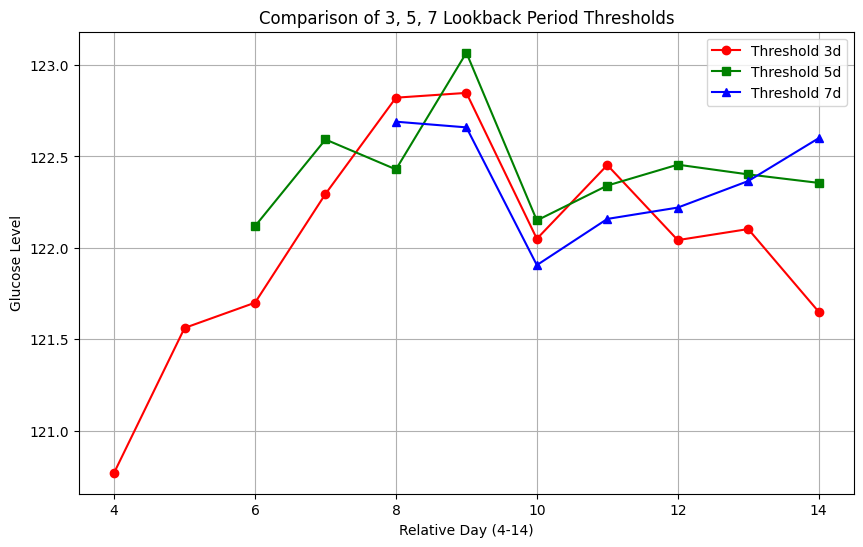

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Filter data for the relative days 4 to 14
day_range_df = df[(df["Relative_Day"] >= 4) & (df["Relative_Day"] <= 14)]

# Compute the mean threshold values for each day
thresholds_by_day = day_range_df.groupby("Relative_Day")[["Threshold_3d", "Threshold_5d", "Threshold_7d"]].mean()

# Plot thresholds over the relative days
plt.figure(figsize=(10, 6))
plt.plot(thresholds_by_day.index, thresholds_by_day["Threshold_3d"], marker='o', color='r', linestyle='-', label="Threshold 3d")
plt.plot(thresholds_by_day.index, thresholds_by_day["Threshold_5d"], marker='s', color='g', linestyle='-', label="Threshold 5d")
plt.plot(thresholds_by_day.index, thresholds_by_day["Threshold_7d"], marker='^', color='b', linestyle='-', label="Threshold 7d")

# Labels and title
plt.xlabel("Relative Day (4-14)")
plt.ylabel("Glucose Level")
plt.title("Comparison of 3, 5, 7 Lookback Period Thresholds")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# Making dataset (add columns)

# Add target varialbe (1H after GE)